<a href="https://colab.research.google.com/github/lIIIIllIIllll/AI_lab/blob/main/Week_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Transfer Learning for Computer Vision Tutorial**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

**Load Data**

In [2]:
import os, zipfile, shutil
from google.colab import files

uploaded = files.upload()
zip_name = next(iter(uploaded))

extract_root = '/content'
with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall(extract_root)

def find_split_root(root):
    for dirpath, dirnames, _ in os.walk(root):
        lower = {d.lower() for d in dirnames}
        if {'train','val'}.issubset(lower):
            return dirpath
    return None

split_root = find_split_root(extract_root)
if split_root is None:
    raise RuntimeError("ZIP 안에서 'train'과 'val' 폴더를 찾지 못했습니다. "
                       "구조가 train/val/<class>/... 형태인지 확인하세요.")

target_dir = '/content/data/hymenoptera_data'
os.makedirs('/content/data', exist_ok=True)

if os.path.islink(target_dir) or os.path.exists(target_dir):
    try:
        if os.path.islink(target_dir):
            os.unlink(target_dir)
        else:
            shutil.rmtree(target_dir)
    except Exception:
        pass

try:
    os.symlink(split_root, target_dir, target_is_directory=True)
    print(f"[OK] Linked {split_root} -> {target_dir}")
except OSError:
    shutil.copytree(split_root, target_dir)
    print(f"[OK] Copied {split_root} -> {target_dir}")

print("train classes:", os.listdir(os.path.join(target_dir, 'train'))[:5])
print("val classes:", os.listdir(os.path.join(target_dir, 'val'))[:5])

Saving hymenoptera_data.zip to hymenoptera_data.zip
[OK] Linked /content/hymenoptera_data -> /content/data/hymenoptera_data
train classes: ['ants', 'bees']
val classes: ['ants', 'bees']


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**Visualize a few images**

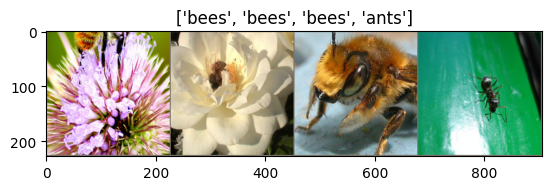

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Training the model**

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

**Visualizing the model predictions**

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

**Finetuning the Convnet (ResNet -> EfficitNet)**

In [10]:
model_ft = models.efficientnet_b3(weights='IMAGENET1K_V1')
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

**Train and evaluate**

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.5999 Acc: 0.7254
val Loss: 0.4674 Acc: 0.8562

Epoch 1/24
----------
train Loss: 0.4476 Acc: 0.8402
val Loss: 0.3453 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.4177 Acc: 0.8238
val Loss: 0.3038 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.3501 Acc: 0.8607
val Loss: 0.2856 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.3708 Acc: 0.8279
val Loss: 0.2546 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.2969 Acc: 0.8811
val Loss: 0.2420 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.3290 Acc: 0.8730
val Loss: 0.2336 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3129 Acc: 0.8566
val Loss: 0.2159 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.2936 Acc: 0.8893
val Loss: 0.2462 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3107 Acc: 0.8648
val Loss: 0.2222 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2893 Acc: 0.8975
val Loss: 0.2339 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3139 Acc: 0.8648
val Loss: 0.2171 Acc: 0.9216

Epoch 12/24
----------
t

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


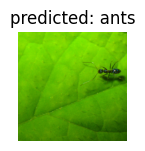

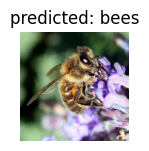

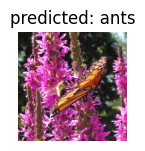

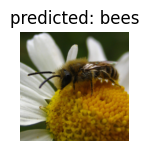

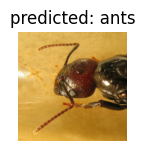

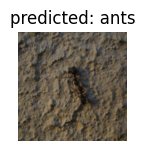

In [15]:
visualize_model(model_ft)

**ConvNet as fixed feature extractor (ResNet -> EfficientNet)**

In [19]:
model_conv = torchvision.models.efficientnet_b3(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.classifier[1].in_features
model_conv.classifier[1] = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

**Train and evaluate**

In [20]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.6023 Acc: 0.6557
val Loss: 0.4843 Acc: 0.8431

Epoch 1/24
----------
train Loss: 0.4717 Acc: 0.8115
val Loss: 0.3808 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4462 Acc: 0.7664
val Loss: 0.3337 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4026 Acc: 0.8238
val Loss: 0.3119 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.3978 Acc: 0.8279
val Loss: 0.3131 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3858 Acc: 0.8402
val Loss: 0.3018 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.3474 Acc: 0.8811
val Loss: 0.2787 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3755 Acc: 0.8197
val Loss: 0.2729 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3795 Acc: 0.8361
val Loss: 0.3045 Acc: 0.8627

Epoch 9/24
----------
train Loss: 0.3904 Acc: 0.8279
val Loss: 0.2996 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.3845 Acc: 0.8566
val Loss: 0.2996 Acc: 0.8562

Epoch 11/24
----------
train Loss: 0.3811 Acc: 0.8156
val Loss: 0.2973 Acc: 0.8954

Epoch 12/24
----------
t

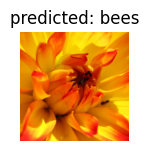

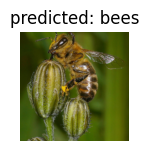

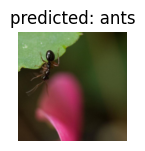

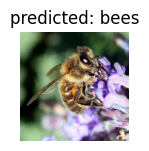

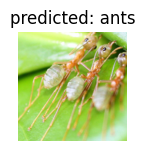

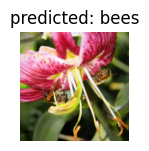

In [21]:
visualize_model(model_conv)

plt.ioff()
plt.show()

**Inference on custom images**

In [22]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

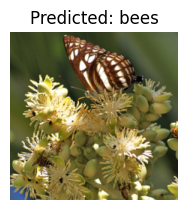

In [23]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()